## Fama French data

In [3]:
import pandas as pd
ffrenchdata = pd.read_csv("Data/F-F_Research_Data_Factors_daily.csv",skiprows= 4)
ffrenchdata.set_index("Unnamed: 0",inplace=True)
ffrenchdata.index.name = "Date"
ffrenchdata = ffrenchdata.iloc[:-1]
ffrenchdata.index = pd.to_datetime(ffrenchdata.index, format='%Y%m%d')
portfolio_size = pd.read_csv("Data/Portfolios_Formed_on_ME_daily.csv",skiprows = 12)
portfolio_size.set_index("Unnamed: 0",inplace=True)
portfolio_size.index.name = "Date"
portfolio_size = portfolio_size.loc[:"20241231"] #Only value weighted decile portfolio
portfolio_size.index = pd.to_datetime(portfolio_size.index, format='%Y%m%d')

C:\Users\Usuario1\AppData\Local\Temp\ipykernel_15336\1652144325.py:7: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  portfolio_size = pd.read_csv("Data/Portfolios_Formed_on_ME_daily.csv",skiprows = 12)


In [67]:
small_caps = ["Lo 10", "Dec 2", "Dec 3"]  # Smallest market cap deciles
big_caps = ["Dec 8", "Dec 9", "Hi 10"]  # Largest market cap deciles
prueba = pd.DataFrame()
portfolio_size[small_caps + big_caps] = portfolio_size[small_caps + big_caps].astype(float)
prueba["SMB"] = portfolio_size[small_caps].mean(axis=1) - portfolio_size[big_caps].mean(axis=1)

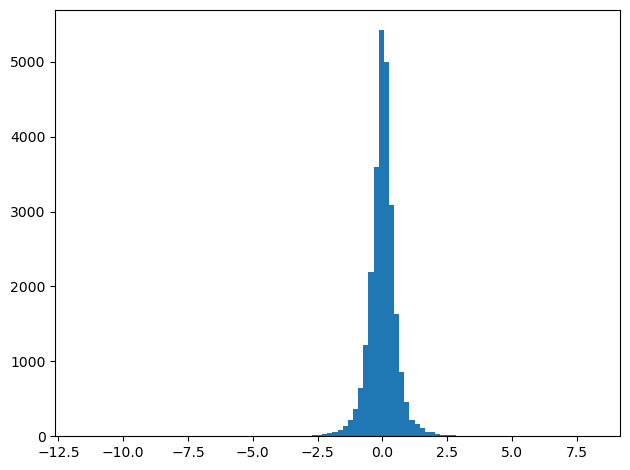

In [32]:
import matplotlib.pyplot as plt
plt.hist(ffrenchdata["SMB"],bins = 100)
plt.tight_layout()

Classic Strategy Statistics:
Annualized Return: 1.0283508500772798
Annualized Volatility: 9.438481616456626
Sharpe Ratio: 0.10895299602896734


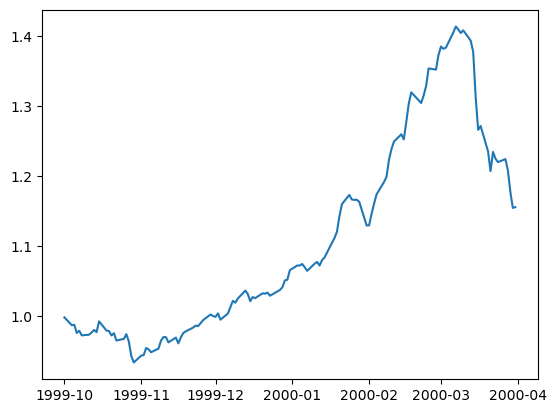

In [10]:
import matplotlib.pyplot as plt
smb_cumulative = (1 + ffrenchdata["SMB"].loc["1999-10-01":"2000-03-31"]/100).cumprod()
annual_factor = 252
plt.plot(smb_cumulative)
daily_mean = ffrenchdata["SMB"].mean()
daily_vol = ffrenchdata["SMB"].std()
print("Classic Strategy Statistics:")
print("Annualized Return:", daily_mean * annual_factor)
print("Annualized Volatility:", daily_vol * (annual_factor ** 0.5))
print("Sharpe Ratio:", (daily_mean / daily_vol) * (annual_factor ** 0.5))

## Strategy:
1. Find Mag7 beta for the SMB and hedge out the effects

In [10]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [1]:
#Define Start and end dates for our strategy:
start_date = "01-01-2021"
end_date = "01-01-2025"


In [2]:
#Process bbg data of retruns
bbg_data = pd.read_csv("Data/bbg_data.csv", index_col=0)
bbg_data.index.name = "Date"
bbg_data.index = pd.to_datetime(bbg_data.index)
ret_columns = [col for col in bbg_data.columns if "return" in col]
bbg_data = bbg_data[ret_columns]
bbg_data = bbg_data.loc[start_date:end_date]

NameError: name 'pd' is not defined

In [33]:
mag7_ret_eq = bbg_data.mean(axis = 1)/100

In [34]:
mag7_port_cumulative = (1 + mag7_ret_eq).cumprod()

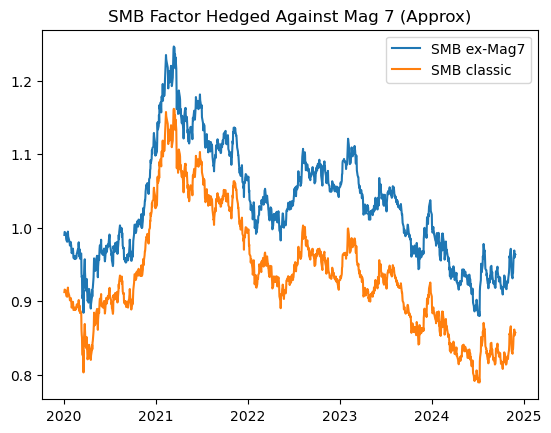

Regression-based Hedge:
Annualized Return (ex Mag7): 2.8950164819974977e-15
Annualized Vol (ex Mag7): 12.32510180100768
Sharpe Ratio (ex Mag7): 2.348878353086549e-16
                            OLS Regression Results                            
Dep. Variable:                    SMB   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     27.14
Date:                Tue, 18 Feb 2025   Prob (F-statistic):           2.21e-07
Time:                        16:59:13   Log-Likelihood:                -1441.7
No. Observations:                1237   AIC:                             2887.
Df Residuals:                    1235   BIC:                             2898.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t 

In [43]:
mag7_df = pd.DataFrame({
    "MAG7_RET": mag7_ret_eq
})
# Example: Keep data from 2020 onward to focus on the last ~3 years
SMB = ffrenchdata['SMB'].loc[start_date:]  # official SMB from Ken French
MAG7 = mag7_df['MAG7_RET'].loc[start_date:]    # your custom Mag 7 daily returns

# Align on common dates
common_idx = SMB.index.intersection(MAG7.index)
SMB = SMB.loc[common_idx]
MAG7 = MAG7.loc[common_idx]

# 1) Regress SMB on Mag7
X = sm.add_constant(MAG7)  # add constant for alpha
y = SMB
model = sm.OLS(y, X).fit()

# 2) The fitted values and residual
SMB_fitted = model.predict(X)       # alpha + beta*Mag7
SMB_exMag7 = SMB - SMB_fitted       # residual (orthogonalized)

# Optionally add back alpha if you want to keep the average return
# SMB_exMag7 = (model.params['const'] + SMB_exMag7)

# 3) Plot the cumulative returns of the “ex–Mag7” version
SMB_exMag7_cum = (1 + SMB_exMag7 / 100).cumprod()
plt.plot(SMB_exMag7_cum, label='SMB ex-Mag7')
plt.plot(smb_cumulative.loc[start_date:end_date],label= "SMB classic")
#plt.plot(mag7_port_cumulative,label = "Mag7 returns")
plt.title('SMB Factor Hedged Against Mag 7 (Approx)')
plt.legend()
plt.show()

# 4) Print stats
daily_mean_exMag7 = SMB_exMag7.mean()
daily_vol_exMag7  = SMB_exMag7.std()
annual_factor = 252  # daily
ann_ret_exMag7 = daily_mean_exMag7 * annual_factor
ann_vol_exMag7 = daily_vol_exMag7 * (annual_factor**0.5)
sharpe_exMag7  = ann_ret_exMag7 / ann_vol_exMag7

print("Regression-based Hedge:")
print("Annualized Return (ex Mag7):", ann_ret_exMag7)
print("Annualized Vol (ex Mag7):", ann_vol_exMag7)
print("Sharpe Ratio (ex Mag7):", sharpe_exMag7)
print(model.summary())


# Creating the SMB factor

In [2]:
import pandas as pd

nyse_data = pd.read_csv("Data/NYSE_universe.csv",header=[0,1])[2:]
nyse_data.set_index([('Unnamed: 0_level_0',                       'Unnamed: 0_level_1')],inplace=True)
nyse_data.index.name = "Date"

In [3]:
nyse_data.index = pd.to_datetime(nyse_data.index)

In [4]:
monthly_data = nyse_data.resample('M').last()


In [5]:
monthly_data[("SKYX US Equity","PX_LAST")]["2022-01"]

Date
2022-01-31    0.001
Freq: M, Name: (SKYX US Equity, PX_LAST), dtype: float64

In [6]:
# Size (market cap)
size_df = monthly_data.xs('CUR_MKT_CAP', axis=1, level=1)

# Market-to-book or book-to-market
mb_df = monthly_data.xs('MARKET_CAPITALIZATION_TO_BV', axis=1, level=1)
# If this is M/B, invert it to get B/M:
bm_df = 1 / mb_df

# (Optional) If you want to compute OP = EBIT / Book_Equity or EBIT / Assets
ebit_df = monthly_data.xs('EBIT', axis=1, level=1)
assets_df = monthly_data.xs('BS_TOT_ASSET', axis=1, level=1)
# For illustration, define OP = EBIT / Assets:
op_df = ebit_df / assets_df

# (Optional) For INV = asset growth, you need the previous month's assets
# We can shift by 1 to get last month's assets, then compute growth
assets_lag = assets_df.shift(1)
inv_df = (assets_df - assets_lag) / assets_lag  # approximate % growth in total assets

# (Optional) If you only have 'PX_LAST', convert to returns:
px_last_df = monthly_data.xs('PX_LAST', axis=1, level=1)
ret_df = px_last_df.pct_change()  # approximate monthly returns


In [7]:
def create_2x3_labels(size_series, style_series):
    """
    size_series: Series of size for one month, index = tickers
    style_series: Series of characteristic (e.g. B/M) for the same month, index = tickers
    Returns a Series of labels, e.g. 'S-L', 'S-M', 'S-H', 'B-L', etc.
    """
    # Drop missing data
    df = pd.concat([size_series, style_series], axis=1).dropna()
    if df.empty:
        return pd.Series(index=size_series.index, dtype='object')
    
    # Breakpoint for size (median)
    size_median = df.iloc[:, 0].median()
    # Breakpoints for style (30% and 70%):
    style_30 = df.iloc[:, 1].quantile(0.3)
    style_70 = df.iloc[:, 1].quantile(0.7)

    labels = []
    for ticker, row in df.iterrows():
        sz = row.iloc[0]
        st = row.iloc[1]
        size_label = 'S' if sz <= size_median else 'B'

        if st <= style_30:
            style_label = 'L'  # e.g. "Low" for B/M, or "Growth"
        elif st > style_70:
            style_label = 'H'  # e.g. "High" for B/M, or "Value"
        else:
            style_label = 'M'  # "Middle"
        
        labels.append(size_label + '-' + style_label)
    
    return pd.Series(labels, index=df.index)


In [8]:
def construct_2x3_portfolio_returns(size_df, style_df, ret_df):
    """
    Constructs 2x3 portfolios (S-L, S-M, S-H, B-L, B-M, B-H) using:
      - size_df   : DataFrame of market caps (index = dates, columns = tickers)
      - style_df  : DataFrame of the 'style' measure (e.g. B/M, OP, or INV)
      - ret_df    : DataFrame of returns (index = dates, columns = tickers)
      
    Returns
    -------
    portfolio_returns : DataFrame
        Index = dates, columns = ['S-L','S-M','S-H','B-L','B-M','B-H'].
        Each cell is the equal-weighted average return of that portfolio in that month.
        
    Notes
    -----
    - We use the data at date t to assign tickers to bins, 
      then we take the *next* month's returns (date t+1) to compute portfolio performance.
    - If you prefer value weighting, replace the `.mean()` with a weighted average 
      using `size_df.loc[date]` as weights.
    """
    port_cols = ['S-L','S-M','S-H','B-L','B-M','B-H']
    portfolio_returns = pd.DataFrame(index=ret_df.index, columns=port_cols, dtype=float)
    
    # We iterate over each date except the very last (since we need the next month)
    for i in range(len(ret_df.index) - 1):
        date = ret_df.index[i]
        next_month = ret_df.index[i+1]
        
        # Current month's size & style
        size_series = size_df.loc[date]
        style_series = style_df.loc[date]
        
        # Assign each stock to a bin
        labels = create_2x3_labels(size_series, style_series)
        
        # Next month's returns
        next_ret = ret_df.loc[next_month].dropna()
        
        # Align returns with labels (so we only group tickers that have labels)
        valid_tickers = labels.dropna().index.intersection(next_ret.index)
        grouped = next_ret[valid_tickers].groupby(labels[valid_tickers])
        
        # Equal-weighted average return in each bucket
        avg_ret = grouped.mean()
        
        # Store results
        for bucket in avg_ret.index:
            portfolio_returns.loc[next_month, bucket] = avg_ret.loc[bucket]
    return portfolio_returns.iloc[1:]


In [11]:
max_column = ret_df.loc[pd.Timestamp('2022-02-28')].idxmax()
print(max_column)


SKYX US Equity


In [12]:
# B/M-based 2×3
portfolio_returns_BM = construct_2x3_portfolio_returns(size_df, bm_df, ret_df)

# OP-based 2×3
portfolio_returns_OP = construct_2x3_portfolio_returns(size_df, op_df, ret_df)

# INV-based 2×3
portfolio_returns_INV = construct_2x3_portfolio_returns(size_df, inv_df, ret_df)


In [13]:
portfolio_returns_BM.loc[pd.Timestamp('2022-02-28')]

S-L    41.184041
S-M     0.007291
S-H    -0.000675
B-L    -0.019759
B-M     0.008615
B-H     0.006260
Name: 2022-02-28 00:00:00, dtype: float64

In [10]:
portfolio_returns_INV

NameError: name 'portfolio_returns_INV' is not defined

In [101]:


# 4) SMB(B/M), SMB(OP), SMB(INV)
portfolio_returns_BM['SMB_BM'] = (
    (portfolio_returns_BM['S-L'] + portfolio_returns_BM['S-M'] + portfolio_returns_BM['S-H']) / 3
    - (portfolio_returns_BM['B-L'] + portfolio_returns_BM['B-M'] + portfolio_returns_BM['B-H']) / 3
)

portfolio_returns_OP['SMB_OP'] = (
    (portfolio_returns_OP['S-L'] + portfolio_returns_OP['S-M'] + portfolio_returns_OP['S-H']) / 3
    - (portfolio_returns_OP['B-L'] + portfolio_returns_OP['B-M'] + portfolio_returns_OP['B-H']) / 3
)

portfolio_returns_INV['SMB_INV'] = (
    (portfolio_returns_INV['S-L'] + portfolio_returns_INV['S-M'] + portfolio_returns_INV['S-H']) / 3
    - (portfolio_returns_INV['B-L'] + portfolio_returns_INV['B-M'] + portfolio_returns_INV['B-H']) / 3
)

# 5) Final SMB factor = average of the three SMB components
smb_bm = portfolio_returns_BM['SMB_BM']
smb_op = portfolio_returns_OP['SMB_OP']
smb_inv = portfolio_returns_INV['SMB_INV']

smb = (smb_bm + smb_op) / 2


In [112]:
smb = smb.drop(pd.Timestamp('2022-02-28'))

In [113]:
cumul = (1+smb).cumprod()

In [130]:
smb

Date
2018-02-28   -0.004765
2018-03-31    0.016164
2018-04-30    0.018187
2018-05-31    0.048841
2018-06-30    0.011269
                ...   
2024-10-31    0.026083
2024-11-30    0.031553
2024-12-31    0.045962
2025-01-31   -0.017706
2025-02-28    0.012769
Length: 84, dtype: float64

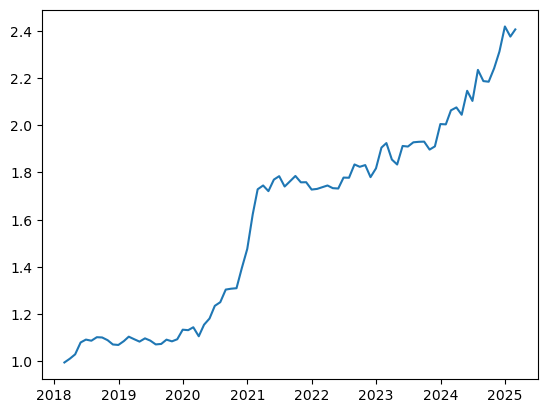

In [114]:
plt.plot(cumul)

In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

# Step 1: Data Collection
# Fetch stock data for small-cap and large-cap indices
def get_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data['Close']

# Example: Russell 2000 (small-cap) and S&P 500 (large-cap)
start_date = "2010-01-01"
end_date = "2025-02-20"
small_cap = get_stock_data("^RUT", start_date, end_date)
large_cap = get_stock_data("^GSPC", start_date, end_date)

# Load innovation metrics from a CSV file (replace with actual dataset)
# Columns: Date, Innovation_Index (e.g., GII), VC_Funding, Patent_Filings
innovation_data = pd.read_csv("innovation_metrics.csv", parse_dates=["Date"], index_col="Date")

# Step 2: Calculate Innovation Volatility
# Rolling standard deviation as a measure of volatility
innovation_data['Volatility'] = innovation_data['Innovation_Index'].rolling(window=12).std()

# Step 3: Merge Stock Data and Innovation Data
data = pd.DataFrame({
    "Small_Cap": small_cap,
    "Large_Cap": large_cap,
    "Innovation_Index": innovation_data['Innovation_Index'],
    "Innovation_Volatility": innovation_data['Volatility']
}).dropna()

# Step 4: Correlation Analysis
small_cap_corr, _ = pearsonr(data['Small_Cap'], data['Innovation_Volatility'])
large_cap_corr, _ = pearsonr(data['Large_Cap'], data['Innovation_Volatility'])

print(f"Correlation between Small-Cap Performance and Innovation Volatility: {small_cap_corr:.2f}")
print(f"Correlation between Large-Cap Performance and Innovation Volatility: {large_cap_corr:.2f}")

# Step 5: Regression Analysis
X = data[['Innovation_Index', 'Innovation_Volatility']]
y_small_cap = data['Small_Cap']
y_large_cap = data['Large_Cap']

model_small_cap = LinearRegression().fit(X, y_small_cap)
model_large_cap = LinearRegression().fit(X, y_large_cap)

print("Small-Cap Regression Coefficients:", model_small_cap.coef_)
print("Large-Cap Regression Coefficients:", model_large_cap.coef_)

# Step 6: Visualization
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Small_Cap'], label="Small-Cap Performance", color='blue')
plt.plot(data.index, data['Large_Cap'], label="Large-Cap Performance", color='green')
plt.plot(data.index, data['Innovation_Volatility'] * 1000, label="Innovation Volatility (Scaled)", color='red', linestyle='--')
plt.legend()
plt.title("Stock Performance vs Innovation Volatility")
plt.xlabel("Date")
plt.ylabel("Performance / Volatility")
plt.show()



[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


FileNotFoundError: [Errno 2] No such file or directory: 'innovation_metrics.csv'

In [14]:
pip install yfinance --upgrade


  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/09/05/28664524fcc67c078313d482bf25fe403e9399130622cfc89e185ec0abf6/yfinance-0.2.54-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/108.7 kB ? eta -:--:--
   ---------------------------------------- 108.7/108.7 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.31
    Uninstalling yfinance-0.2.31:
      Successfully uninstalled yfinance-0.2.31
Note: you may need to restart the kernel to use updated packages.
